<a href="https://colab.research.google.com/github/Chimamuelo/Simple-Cnn-Pytorch/blob/main/simple_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Load data without converting to tensors
trainset_img = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)

Files already downloaded and verified


In [ ]:
#Calculate mean and std of dataset
data=trainset_img.data/255

#RGB
mean=data.mean(axis = (0,1,2))
std=data.std(axis = (0,1,2))

print(f"Mean{mean} std{std}")

Mean[0.49139968 0.48215841 0.44653091] std[0.24703223 0.24348513 0.26158784]


In [ ]:
# Get pixel values
pixels=trainset_img[0][0].getdata()
pixel_sequence=list(pixels)

In [ ]:

pix=np.array(pixel_sequence)

#Original image is an RGB 32x32
print(pix.shape)

(1024, 3)


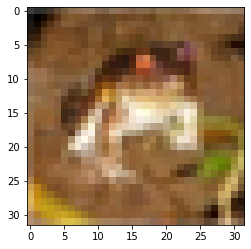

In [ ]:
#Show image without normalization
plt.imshow(trainset_img[0][0])

In [ ]:
#Transform image data (pixel values from 0-255) -> TENSOR (with range from 0-1) and normalize
transformation = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean),std)])


In [ ]:
batch_size = 8

#Download data and apply the transformation
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,transform=transformation)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,transform=transformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
data_norm=trainset.data

In [ ]:
data_norm.shape

(50000, 32, 32, 3)

In [ ]:
#Declare np array of normalized pixel values (They were tensors)
img_np = np.array(trainset[0][0])

In [ ]:

img_normalized = img_np.transpose(1, 2, 0)

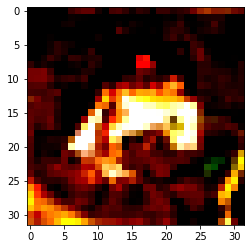

In [ ]:
#Plot normalized image
plt.imshow(img_normalized,interpolation='nearest')
plt.show()

In [ ]:
##Few samples of normalized images
data_iter=iter(trainloader)
img,label=data_iter.next()

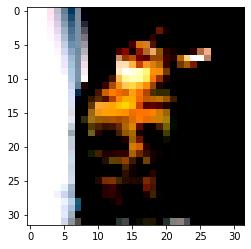

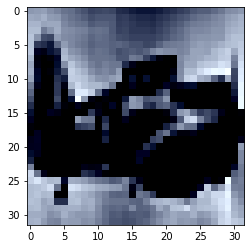

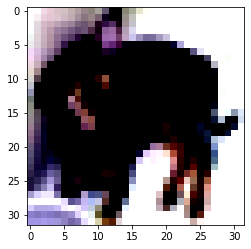

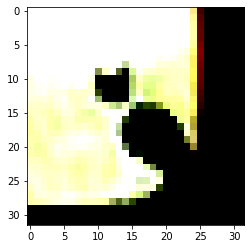

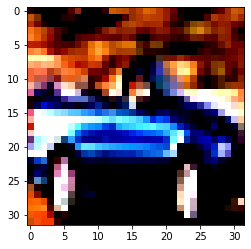

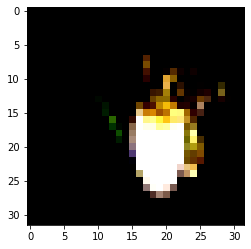

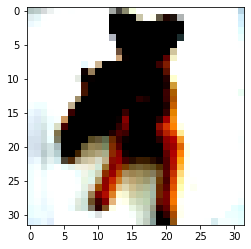

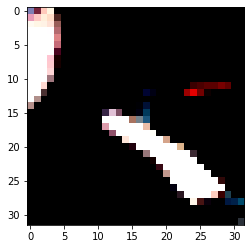

In [ ]:
#Plot normalized images
for i in range(8):
  plt.imshow(torchvision.utils.make_grid(np.transpose(data_iter.next()[0][0],(1,2,0))))
  plt.show()

In [ ]:
#Declare Cnn architecture


class model(nn.Module):
  def __init__(self,in_channel,out_channel):
    super().__init__()
    
    self.conv1=nn.Conv2d(in_channel,out_channel,kernel_size=5,stride=1)
    
    #compare stride with max pool, to try this make stride=1
    self.pool=nn.MaxPool2d(2,2)

    self.conv2=nn.Conv2d(out_channel,32,kernel_size=5,stride=1)
    self.linear=nn.Linear(32*5*5,120)
    self.linear2=nn.Linear(120,84)
    self.out=nn.Linear(84,10)

    
  def forward(self,x):
    
   # x =F.relu(self.conv1(x))
    x=self.pool(F.relu(self.conv1(x)))

    #x =F.relu(self.conv2(x))
    x=self.pool(F.relu(self.conv2(x)))

    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.linear(x))
    x = F.relu(self.linear2(x))
    x = self.out(x)
    return x
    
    


In [ ]:
model=model(3,16)
device = torch.device("cuda")
model.to(device)

model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (linear): Linear(in_features=800, out_features=120, bias=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
!pip install torchmetrics attrdict -q

In [ ]:
import torch.optim as optim
import torchmetrics

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metric = torchmetrics.Accuracy()
metric=metric.to(device)

In [ ]:
N_EPOCHS = 5

In [ ]:
train_losses_step = []
train_losses = []
valid_losses = []
for epoch in range(N_EPOCHS):
  running_loss = 0.0
  model.train()
  for i, data in enumerate(trainloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs=inputs.to(device)
    labels=labels.to(device)

      # zero the parameter gradients
    optimizer.zero_grad()

      # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    batch_acc = metric(outputs,labels)
    running_loss += loss
    train_losses_step.append(loss.item())

  running_loss /= len(trainloader)
  train_losses.append(running_loss.item())
  train_acc = metric.compute()
    
    
  model.eval() 
  val_loss=0
  for i, data in enumerate(testloader, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs=inputs.to(device)
    labels=labels.to(device)


 


    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
   

    batch_acc = metric(outputs,labels)
    val_loss += loss
    

  val_loss /= len(testloader)
  valid_losses.append(val_loss.item())
  valid_acc = metric.compute()
    
  print(f"Epoch: {epoch}, Train loss: {running_loss:.04f} Train acc: {float(train_acc):.04f}, Valid loss: {val_loss} Valid Acc: {float(valid_acc):.04f}")
     
  
      



Epoch: 0, Train loss: 1.4774 Train acc: 0.4592, Valid loss: 1.2569797039031982 Valid Acc: 0.4729
Epoch: 1, Train loss: 1.1656 Train acc: 0.5248, Valid loss: 1.1012367010116577 Valid Acc: 0.5324
Epoch: 2, Train loss: 1.0360 Train acc: 0.5619, Valid loss: 1.0725475549697876 Valid Acc: 0.5654
Epoch: 3, Train loss: 0.9448 Train acc: 0.5882, Valid loss: 0.9925355911254883 Valid Acc: 0.5910
Epoch: 4, Train loss: 0.8873 Train acc: 0.6080, Valid loss: 1.0040204524993896 Valid Acc: 0.6097


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels=images.to(device),labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 65 %


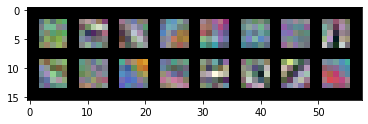

In [ ]:

kernels = model.conv1.weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
kernels=kernels.cpu()


img = torchvision.utils.make_grid(kernels)
plt.imshow(np.transpose(img,(1, 2, 0)))

In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = torchvision.utils.make_grid(tensor, nrow=nrow,normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))


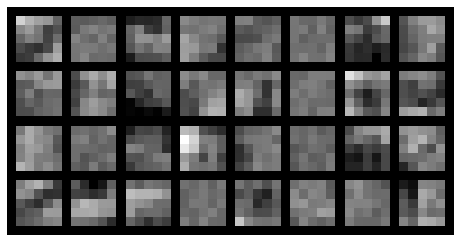

In [ ]:
kernels=model.conv2.weight.detach().clone()
kernels=kernels.cpu()
visTensor(kernels, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.show()